# Evaluating synthetic yeast promoters using Polygraph

In [1]:
import numpy as np
import pandas as pd
import plotnine as p9
import seaborn as sns
import matplotlib.pyplot as plt

import polygraph.input, polygraph.embedding, polygraph.motifs, polygraph.models, polygraph.sequence, polygraph.utils, polygraph.visualize, polygraph.stats
pd.set_option('display.precision', 2)
%matplotlib inline

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Read data

The input file should be a tab or comma separated file with two columns. The first column contains the sequence and the second contains the group. The `read_seqs` function will assign a unique ID to each sequence.

In [2]:
seqs = polygraph.input.read_seqs('yeast_seqs.txt')
seqs.head()

,Sequence,Group
SeqID,,
seq_0,GATGAGTGAAAAATCGTAATGAGTCAGCAAATCACTCTGTACGTTA...,native_high
seq_1,CATCGACTTATTTTTTTTTTTTGATGAAATTTTTCAGATTTTACAA...,native_high
seq_2,GCCTCTTATTTTTTTTTTTTTCGATTTTTGGCCCACAGGTCATATT...,native_high
seq_3,GATGAGTGAAAAATCGTAATGAGTCAGCAAATCACTGTGTACGTTA...,native_high
seq_4,AGAGCGACGCAAACAGCGCGCAGACTCTACGGGTAATAGACTCACA...,native_high


This dataset contains the sequences of selected native yeast promoters as well as 50 random sequences and 50 synthetic promoters each generated by evolution and gradient (Ledidi) methods starting from the random sequences. Further, we have 50 sequences that were generated using the `polygraph.evolve.evolve` function, which optimizes for both predicted activity and similarity to native promoters.

In [3]:
print(seqs.Group.value_counts())

Group
native_high         50
native_low          50
random              50
evolution           50
gradient            50
guided_evolution    50
Name: count, dtype: int64


# 1. Evaluate sequence content

## 1.1 GC content

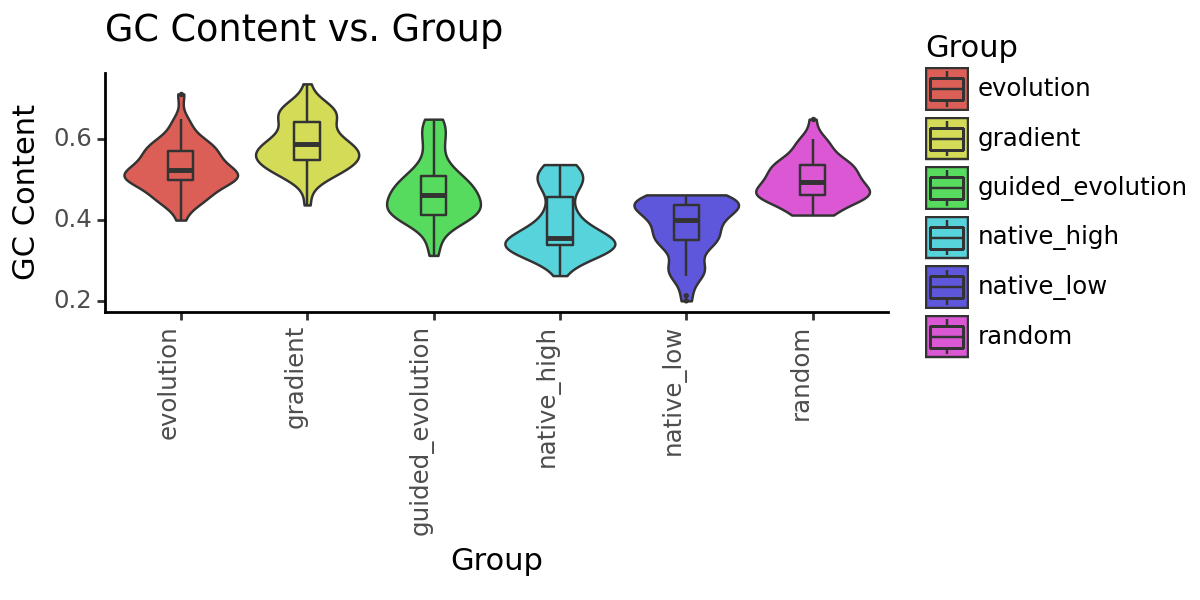

<Figure Size: (600 x 300)>

In [4]:
seqs['GC Content'] = polygraph.sequence.gc(seqs)
polygraph.visualize.boxplot(seqs, value_col='GC Content') + p9.theme(figure_size=(6,3))

In [5]:
polygraph.stats.kruskal_dunn(data=seqs, val_col="GC Content")

{'Kruskal': 1.0667060077212982e-34,
 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
 evolution          1.00e+00  6.59e-03          8.37e-04     2.03e-12   
 gradient           6.59e-03  1.00e+00          1.54e-09     1.09e-22   
 guided_evolution   8.37e-04  1.54e-09          1.00e+00     2.27e-04   
 native_high        2.03e-12  1.09e-22          2.27e-04     1.00e+00   
 native_low         4.47e-14  8.19e-25          2.51e-05     5.90e-01   
 random             9.51e-02  1.20e-05          9.51e-02     8.57e-08   
 
                   native_low    random  
 evolution           4.47e-14  9.51e-02  
 gradient            8.19e-25  1.20e-05  
 guided_evolution    2.51e-05  9.51e-02  
 native_high         5.90e-01  8.57e-08  
 native_low          1.00e+00  4.11e-09  
 random              4.11e-09  1.00e+00  }

## 1.2 length distribution

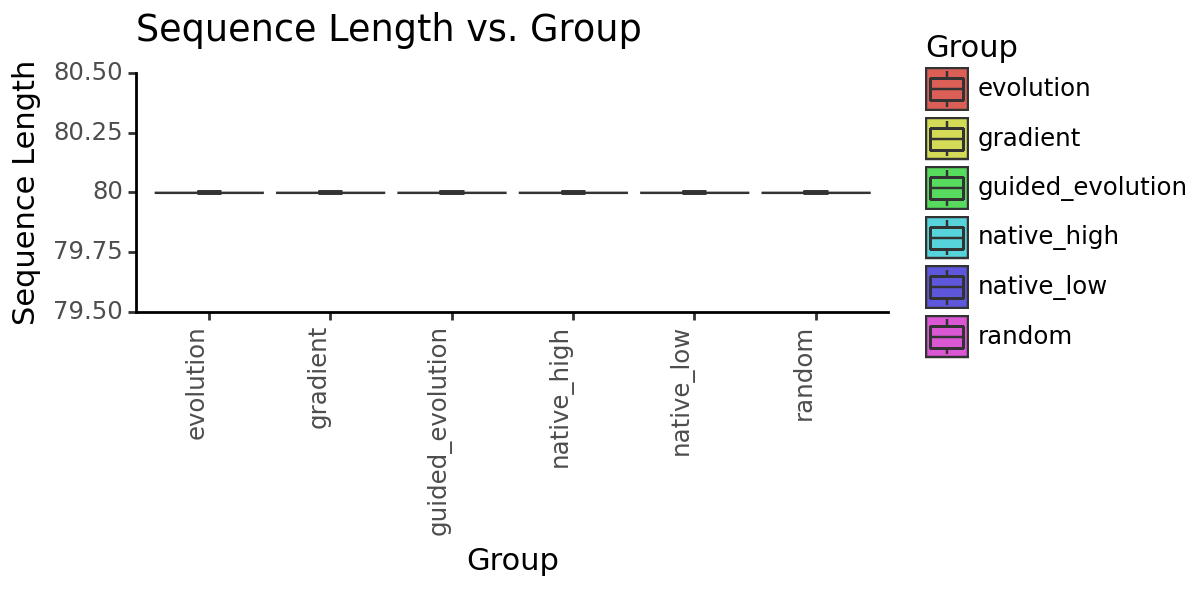

<Figure Size: (600 x 300)>

In [6]:
seqs['Sequence Length'] = seqs.Sequence.apply(len)
polygraph.visualize.boxplot(seqs, value_col='Sequence Length') + p9.theme(figure_size=(6,3))

## 1.3 Edit distance (compared to the nearest reference sequence)

In [7]:
seqs['edit'] = polygraph.sequence.min_edit_distance_from_reference(seqs, reference_group='native_high')

{'Kruskal': 1.1443090346410912e-07, 'Dunn':                   evolution  gradient  guided_evolution  native_low    random
evolution          1.00e+00  5.44e-01          1.60e-04    4.69e-03  7.74e-01
gradient           5.44e-01  1.00e+00          1.26e-05    4.12e-04  6.91e-01
guided_evolution   1.60e-04  1.26e-05          1.00e+00    4.01e-01  6.73e-05
native_low         4.69e-03  4.12e-04          4.01e-01    1.00e+00  2.12e-03
random             7.74e-01  6.91e-01          6.73e-05    2.12e-03  1.00e+00}


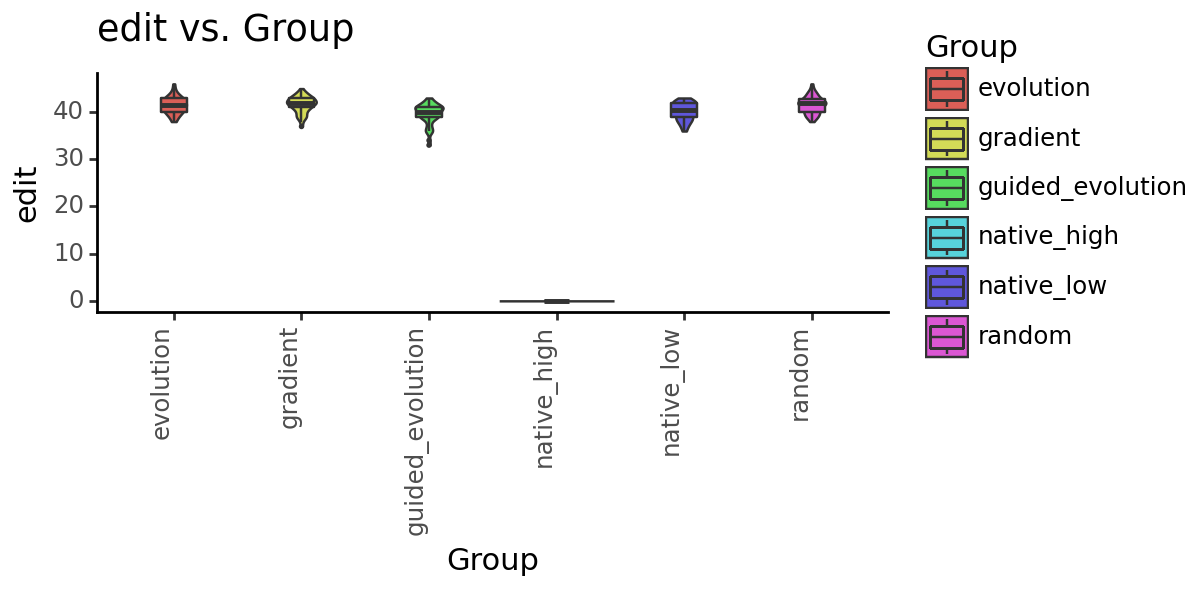

<Figure Size: (600 x 300)>

In [8]:
print(polygraph.stats.kruskal_dunn(seqs[seqs.Group!='native_high'], val_col='edit'))
polygraph.visualize.boxplot(seqs, value_col='edit') + p9.theme(figure_size=(6, 3))

## 1.4 k-mer content

In [9]:
%%time
kmers = polygraph.sequence.kmer_frequencies(seqs=seqs, k=5, normalize=True)
print(kmers.shape)
kmers.iloc[:5, :5]

(300, 1024)
CPU times: user 371 ms, sys: 13.2 ms, total: 384 ms
Wall time: 376 ms


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA
SeqID,,,,,
seq_0,0.01,0.00,0.0,0.01,0.00
seq_1,0.01,0.01,0.0,0.00,0.00
seq_2,0.01,0.01,0.0,0.00,0.00
seq_3,0.01,0.00,0.0,0.01,0.00
seq_4,0.00,0.00,0.0,0.00,0.01


In [10]:
%%time
emb = polygraph.embedding.embedding_analysis(
    kmers, seqs, reference_group='native_high', use_pca=True)

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.6348119988012593
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers
CPU times: user 1min 2s, sys: 3.77 s, total: 1min 6s
Wall time: 8.09 s


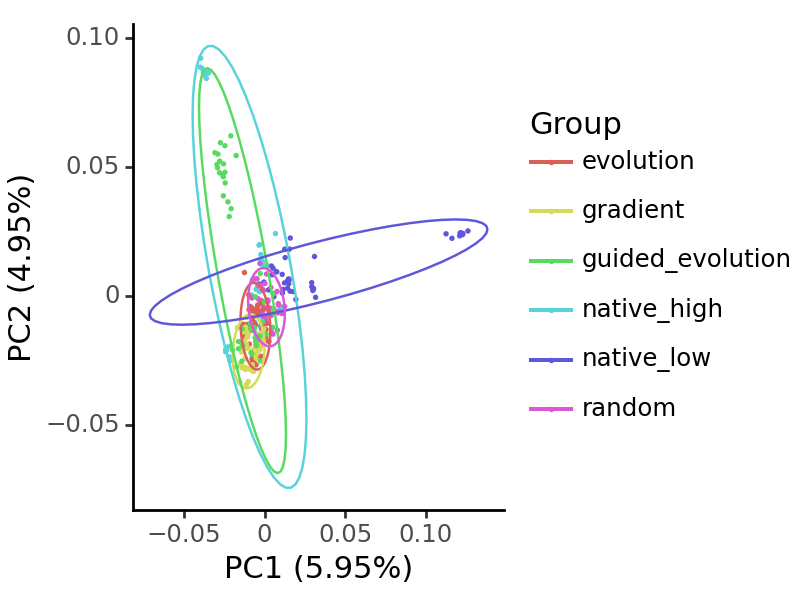

<Figure Size: (400 x 300)>

In [11]:
polygraph.visualize.pca_plot(emb, show_ellipse=True) + p9.theme(figure_size=(4,3))

In [12]:
# Differential k-mer abundance

print("Number of differential k-mers compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential k-mers")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head())

Number of differential k-mers compared to reference
Group
native_low    23
gradient      13
random         7
evolution      3
Name: count, dtype: int64

Top Differential k-mers
           Group  value  score      padj  log2FC
1023    gradient  GCGCG   6.60  4.18e-08    2.80
3069  native_low  TTTTT  -6.20  5.62e-07  -23.47
4092      random  TTTTT  -5.89  4.02e-06   -4.47
1024    gradient  CGCGC   5.76  4.22e-06    2.55
3070  native_low  TTTTC  -5.52  1.71e-05   -5.14


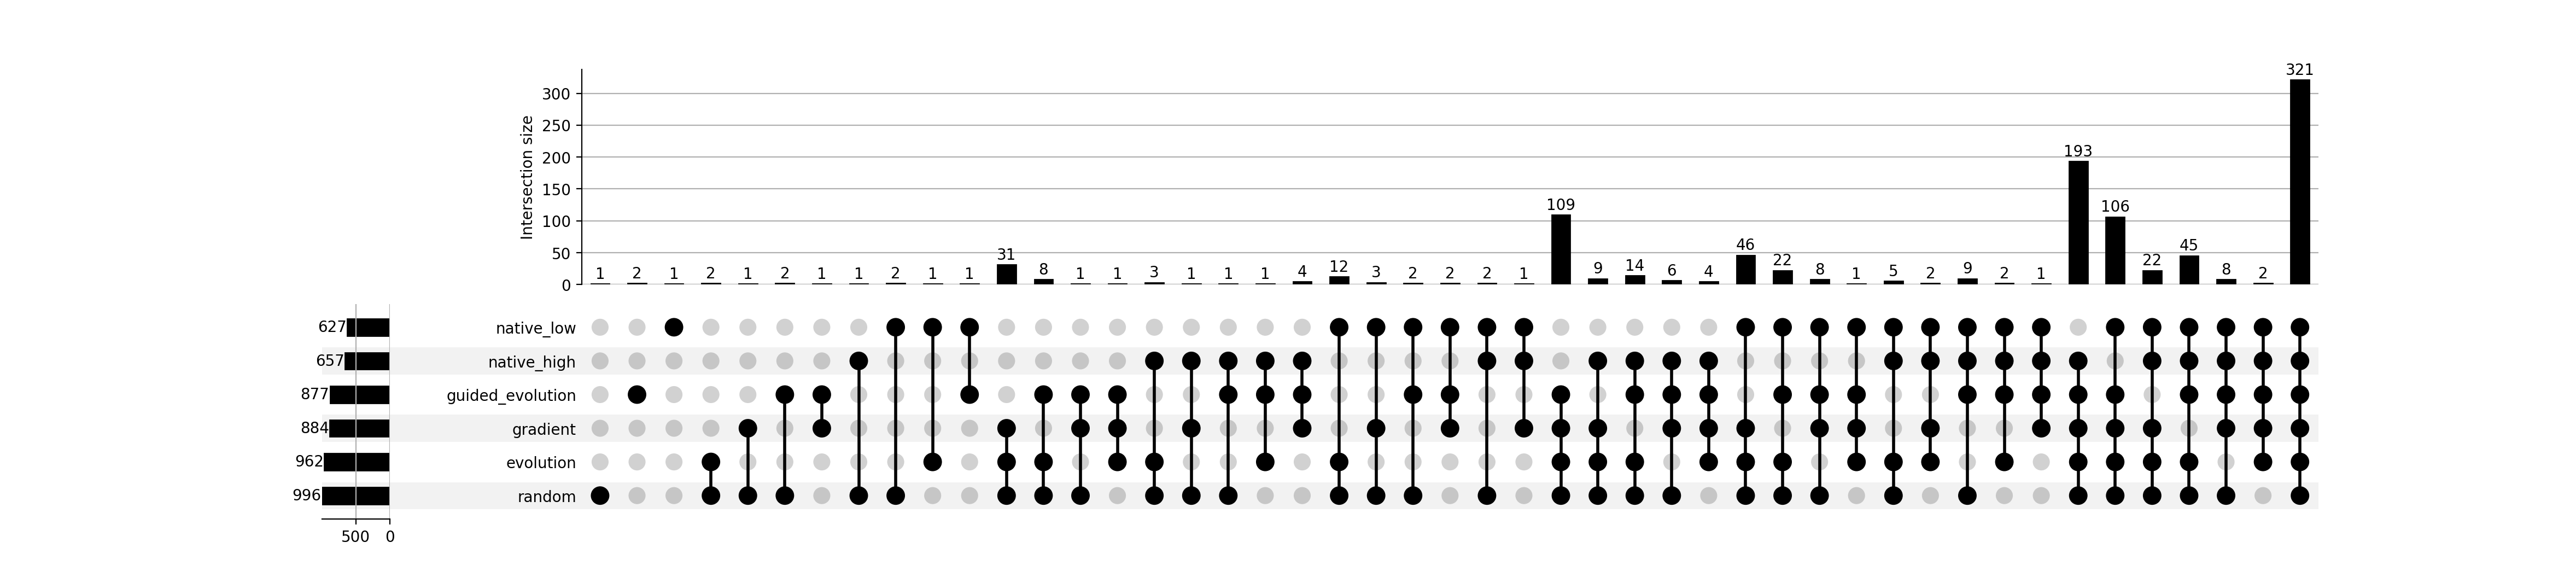

In [13]:
# kmer occurrence
polygraph.visualize.upset_plot(emb)

p-values for proportion of sequences with native nearest neighbor
                  group_prop  ref_prop      pval      padj
Group                                                     
native_low              0.00      0.96  2.63e-26  1.31e-25
random                  0.10      0.96  6.18e-20  1.03e-19
evolution               0.26      0.96  9.78e-14  1.22e-13
gradient                0.02      0.96  1.24e-24  3.10e-24
guided_evolution        0.26      0.92  8.37e-12  8.37e-12


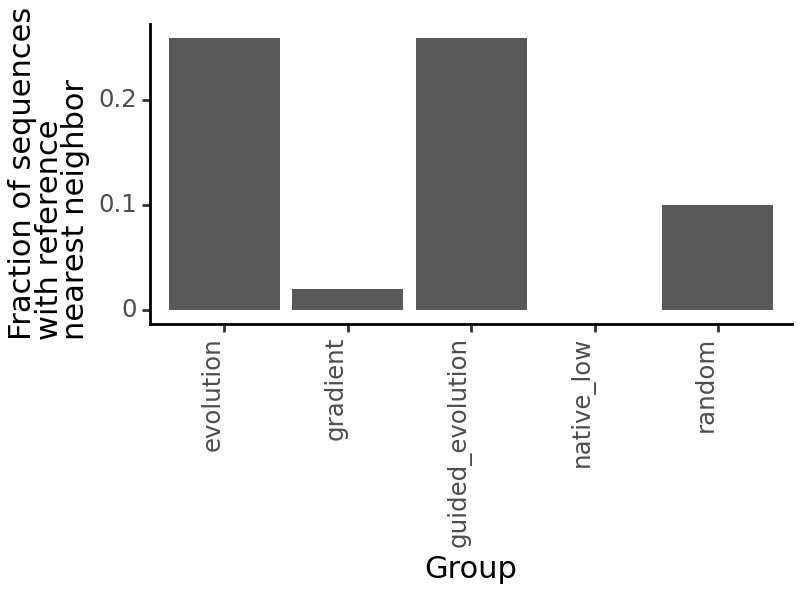

<Figure Size: (400 x 300)>

In [14]:
# 1-NN statistics
print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

# Plot
polygraph.visualize.one_nn_frac_plot(emb, reference_group="native_high") + p9.theme(figure_size=(4,3))

p-values for distance to closest reference
{'Kruskal': 2.2286046759511646e-44, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  8.02e-01          3.01e-10     6.27e-16   
gradient           8.02e-01  1.00e+00          1.33e-09     3.98e-15   
guided_evolution   3.01e-10  1.33e-09          1.00e+00     8.44e-02   
native_high        6.27e-16  3.98e-15          8.44e-02     1.00e+00   
native_low         1.26e-04  4.79e-05          3.23e-24     6.28e-33   
random             5.56e-01  4.27e-01          4.17e-12     3.11e-18   

                  native_low    random  
evolution           1.26e-04  5.56e-01  
gradient            4.79e-05  4.27e-01  
guided_evolution    3.23e-24  4.17e-12  
native_high         6.28e-33  3.11e-18  
native_low          1.00e+00  1.38e-03  
random              1.38e-03  1.00e+00  }


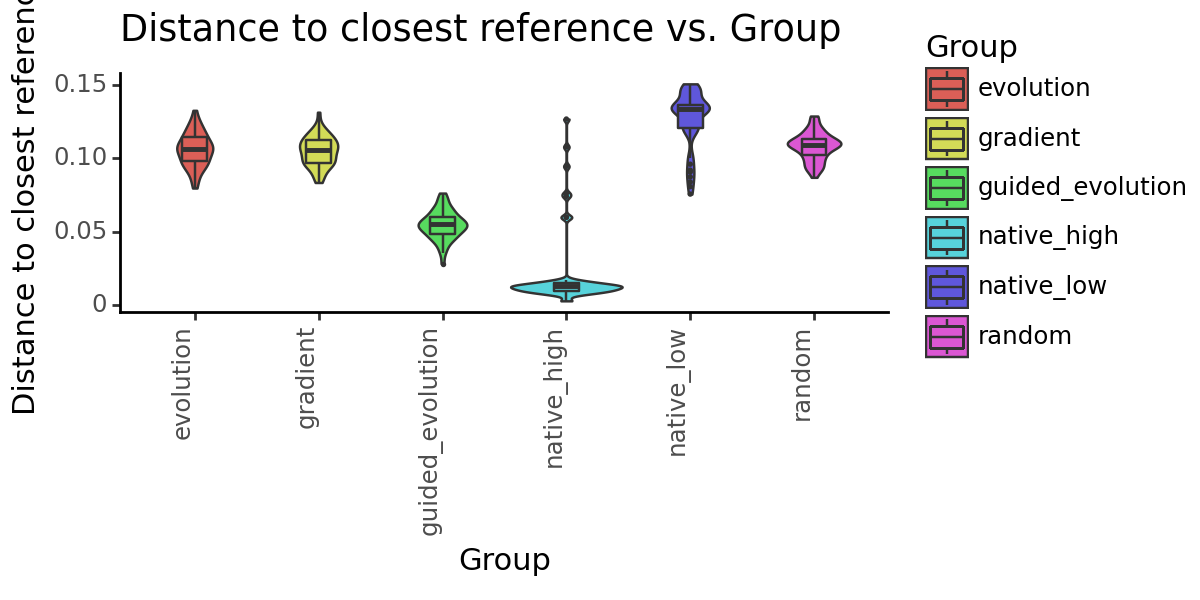

<Figure Size: (600 x 300)>

In [15]:
#Distance to the closest reference sequence
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6,3))

p-values for KNN diversity
{'Kruskal': 8.900023087508012e-24, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  2.73e-10          9.73e-15     4.47e-06   
gradient           2.73e-10  1.00e+00          1.37e-01     1.13e-01   
guided_evolution   9.73e-15  1.37e-01          1.00e+00     1.42e-03   
native_high        4.47e-06  1.13e-01          1.42e-03     1.00e+00   
native_low         2.02e-14  1.78e-01          8.61e-01     2.37e-03   
random             2.31e-01  3.95e-07          3.91e-11     8.50e-04   

                  native_low    random  
evolution           2.02e-14  2.31e-01  
gradient            1.78e-01  3.95e-07  
guided_evolution    8.61e-01  3.91e-11  
native_high         2.37e-03  8.50e-04  
native_low          1.00e+00  9.82e-11  
random              9.82e-11  1.00e+00  }


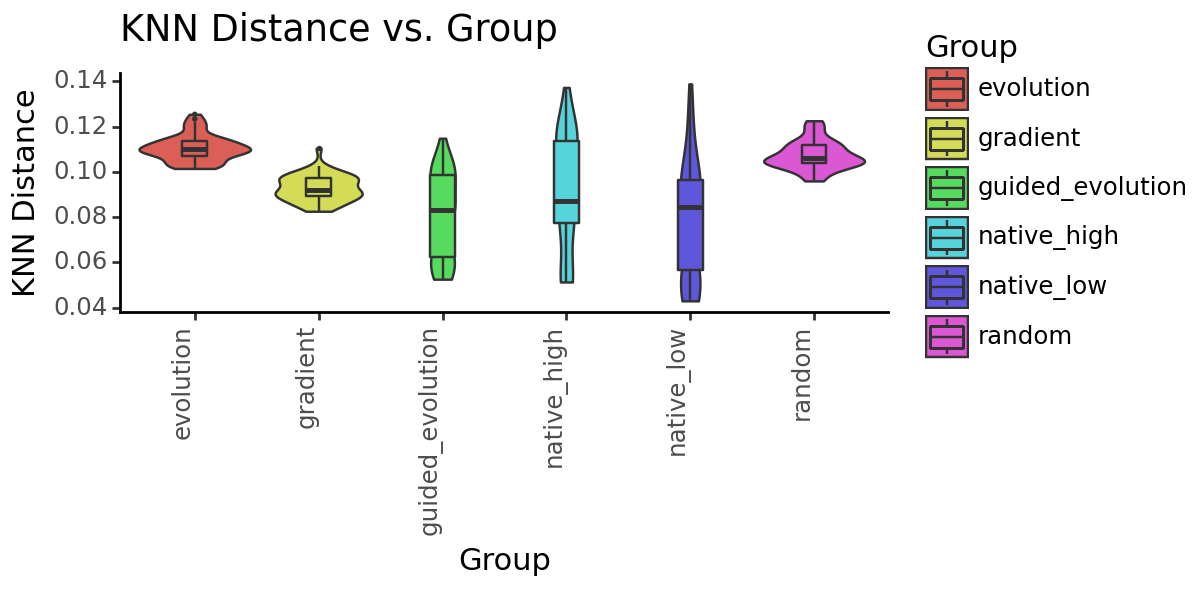

<Figure Size: (600 x 300)>

In [16]:
# KNN distance (diversity metric)
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6,3))

In [17]:
# Performance of a classifier trained to separate each group from the reference
emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
native_low,0.99,0.99
random,0.99,0.99
evolution,0.97,0.97
gradient,0.99,0.99
guided_evolution,0.88,0.88


## 1.5 All-to-all comparisons

The above analyses compare each group of synthetic sequences to the reference group (native_high) one at a time. We may also want to understand how similar these groups are to each other. Below are some all-to-all comparisons.

/opt/conda/lib/python3.8/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
/opt/conda/lib/python3.8/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


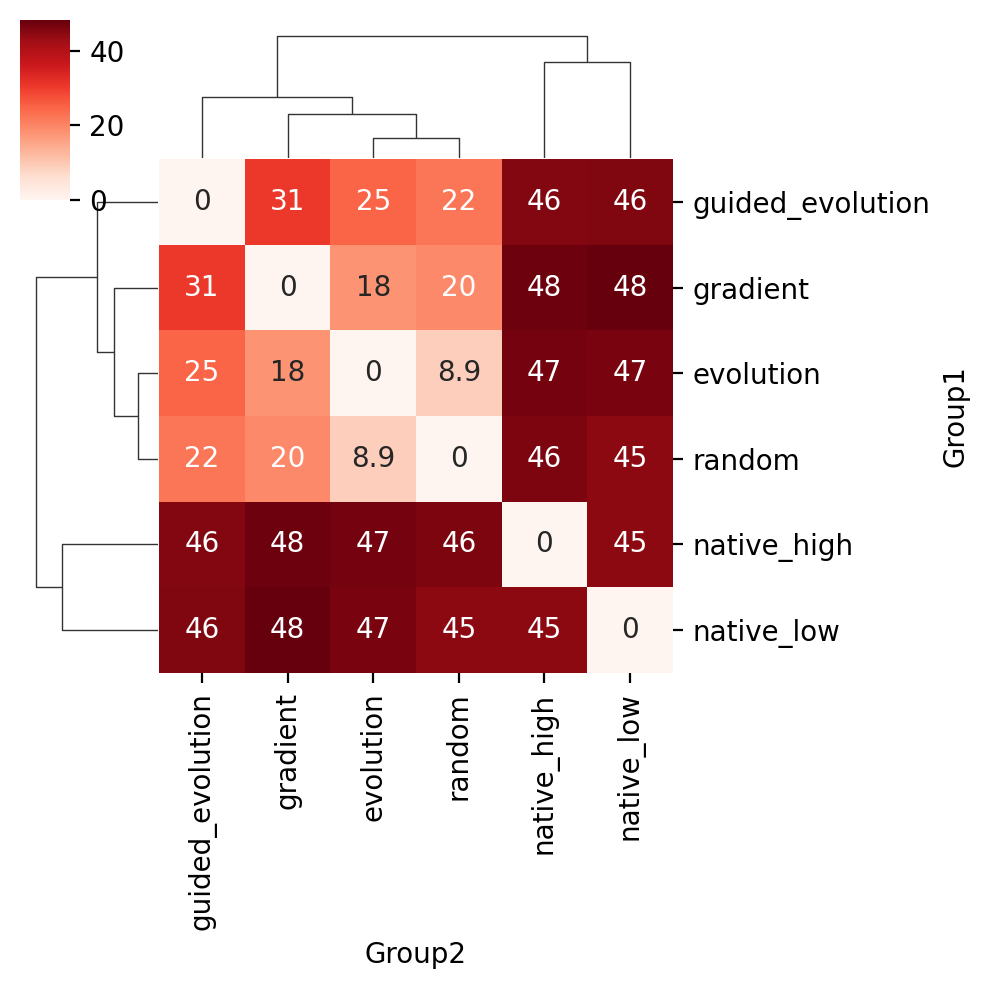

In [18]:
# Average Edit distance
mean_edit = polygraph.sequence.groupwise_mean_edit_dist(seqs)
sns.clustermap(mean_edit, annot=True, cmap="Reds", figsize=(5,5))

In [20]:
# All-to-all fraction of sequences whose nearest neighbors belong to different groups.
emb = polygraph.embedding.joint_1nn(emb, reference_group="native_high", use_pca=True)
emb.uns['1NN_group_probs'].T.style.background_gradient("Blues")

Group,evolution,gradient,guided_evolution,native_high,native_low,random
one_nn_group,,,,,,
evolution,0.000000,0.800000,0.000000,0.000000,0.000000,1.000000
gradient,0.040000,0.100000,0.000000,0.000000,0.000000,0.000000
guided_evolution,0.000000,0.000000,0.740000,0.060000,0.000000,0.000000
native_high,0.000000,0.000000,0.260000,0.920000,0.000000,0.000000
native_low,0.000000,0.000000,0.000000,0.020000,1.000000,0.000000
random,0.960000,0.100000,0.000000,0.000000,0.000000,0.000000


## 1.6 Gapped k-mer embedding

In [23]:
# Count k-mers of length 5 with 2 mismatches
gkm = polygraph.sequence.fastsk(seqs, k=5, m=2)

Length of shortest train sequence: 80
Length of shortest test sequence: 80
Dictionary size = 4 (+1 for unknown char).
g = 5, k = 3, 45600 features
Initializing kernel function


In [27]:
%%time
emb = polygraph.embedding.embedding_analysis(
    gkm, seqs, reference_group='native_high', use_pca=True, max_iter=10000)

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.9953883432062018
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers
CPU times: user 58.9 s, sys: 5.56 s, total: 1min 4s
Wall time: 4.64 s


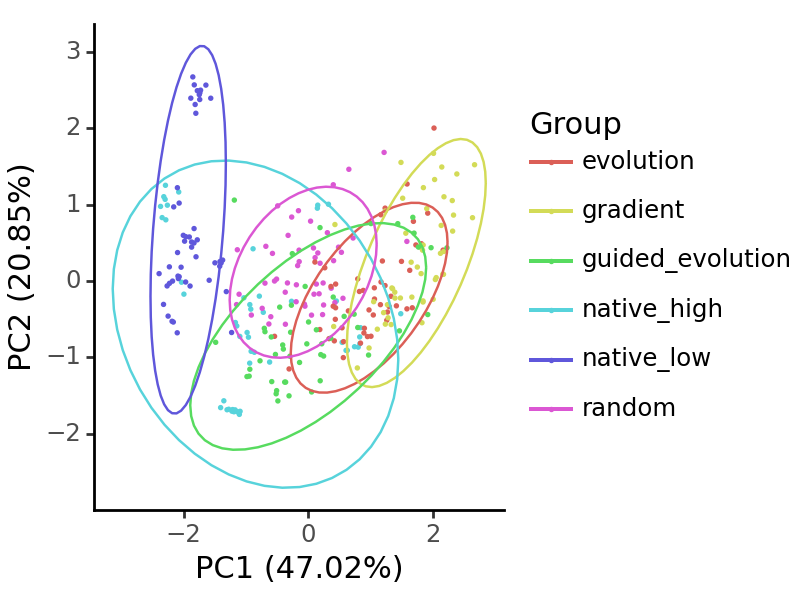

<Figure Size: (400 x 300)>

In [28]:
polygraph.visualize.pca_plot(emb, show_ellipse=True) + p9.theme(figure_size=(4,3))

In [29]:
# Performance of a classifier trained to separate each group from the reference
emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
native_low,1.00,1.00
random,1.00,1.00
evolution,0.98,0.98
gradient,1.00,1.00
guided_evolution,0.98,0.98


# 2. Model based evaluation

In [22]:
# Download yeast sequence-to-promoter activity model
# This was trained on yeast GPRA data from Vaishnav et al. 2022
!wget https://zenodo.org/records/10214625/files/yeast-model.pth

--2024-01-30 19:15:34--  https://zenodo.org/records/10214625/files/yeast-model.pth
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9968513 (9.5M) [application/octet-stream]
Saving to: ‘yeast-model.pth.1’

yeast-model.pth.1   100%[===================>]   9.51M  6.27MB/s    in 1.5s    

2024-01-30 19:15:37 (6.27 MB/s) - ‘yeast-model.pth.1’ saved [9968513/9968513]



In [30]:
import torch
model = torch.load('yeast-model.pth')

## 2.1 Predictions

In [31]:
# Predict promoter activity using the trained model
seqs[['complex_pred', 'defined_pred']] = polygraph.models.predict(seqs, model, batch_size=512, device=0)

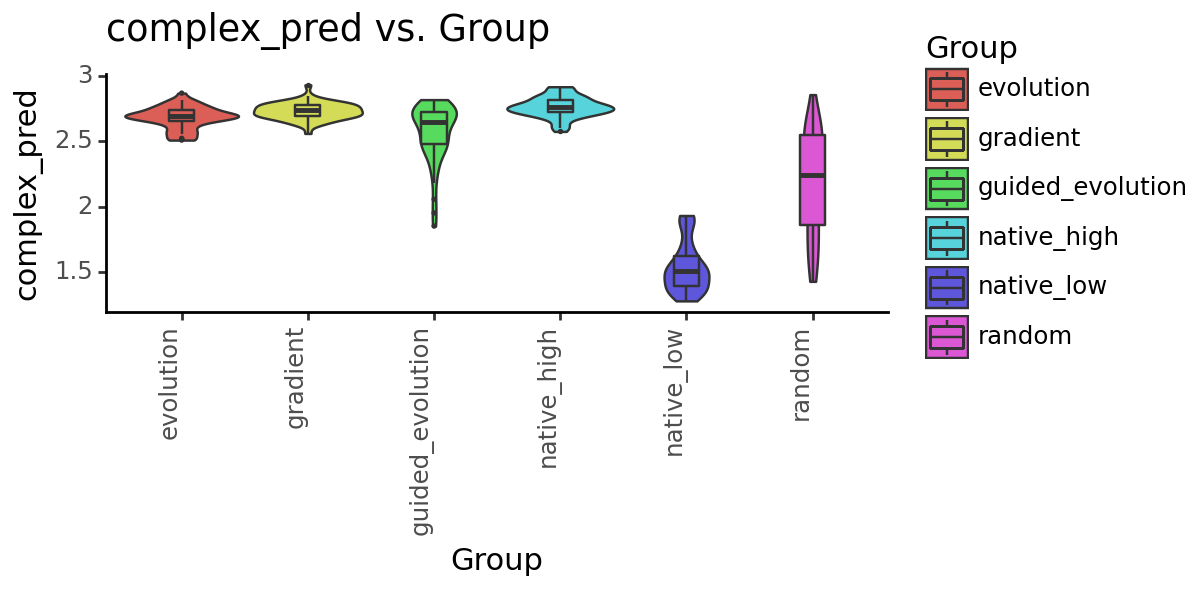

<Figure Size: (600 x 300)>

In [32]:
polygraph.visualize.boxplot(seqs, value_col='complex_pred') + p9.theme(figure_size=(6, 3))

## 2.2 cell type specificity

In [33]:
# Metrics of how specific the promoter activity is to the 'complex' condition.
seqs = polygraph.models.cell_type_specificity(seqs, 'complex_pred', ['defined_pred'])

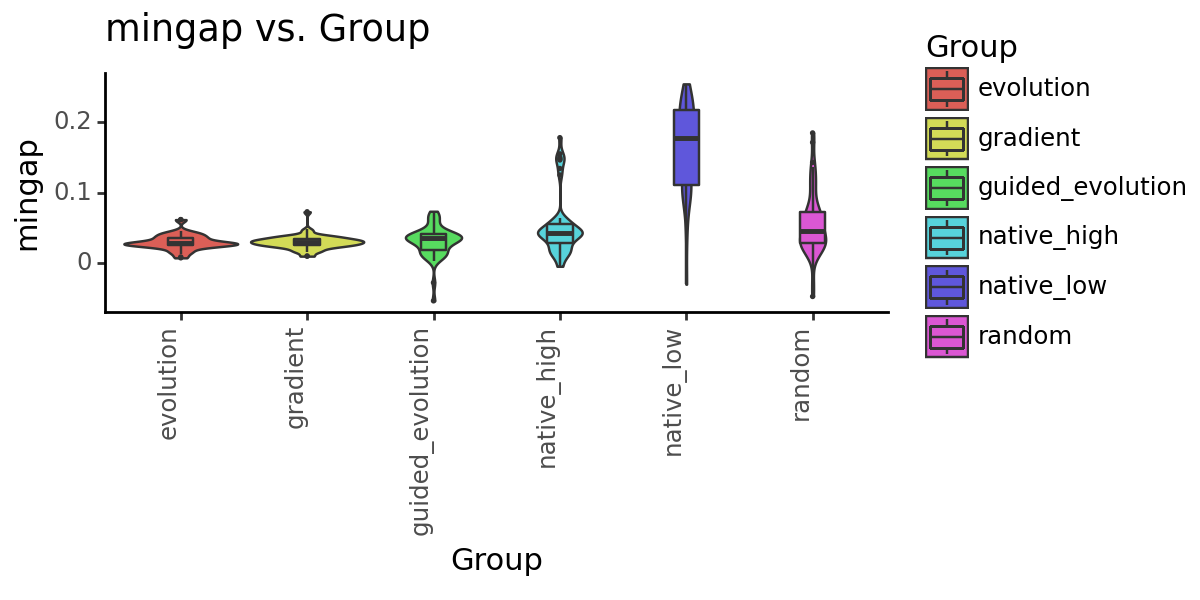

<Figure Size: (600 x 300)>

In [34]:
polygraph.visualize.boxplot(seqs, value_col='mingap') + p9.theme(figure_size=(6, 3))

## 2.3 Model embeddings

In [38]:
%%time
# Embed the sequences using the lower layers of the predictive model
emb = polygraph.models.get_embeddings(seqs, model, batch_size=512, drop_last_layers=4, device=0)
emb.shape

CPU times: user 582 ms, sys: 11.2 ms, total: 593 ms
Wall time: 10.2 ms


(300, 512)

In [39]:
emb = polygraph.embedding.embedding_analysis(emb, seqs=seqs, reference_group='native_high', max_iter=10000, use_pca=True)

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.9946266
UMAP


/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers


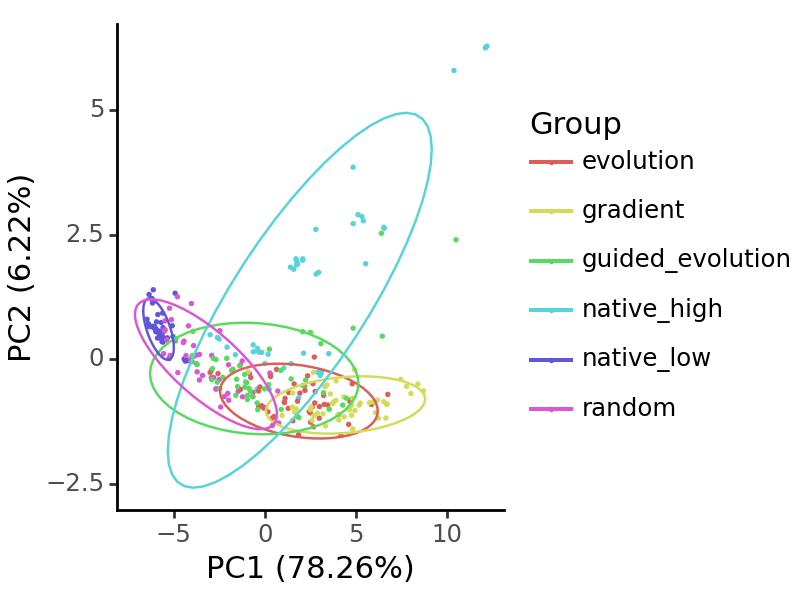

<Figure Size: (400 x 300)>

In [40]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(4, 3))

                  group_prop  ref_prop      pval      padj
Group                                                     
native_low              0.00      1.00  1.98e-29  9.91e-29
random                  0.02      0.92  2.73e-22  4.55e-22
evolution               0.04      0.90  6.18e-20  7.72e-20
gradient                0.02      0.92  2.73e-22  4.55e-22
guided_evolution        0.16      0.88  1.88e-13  1.88e-13


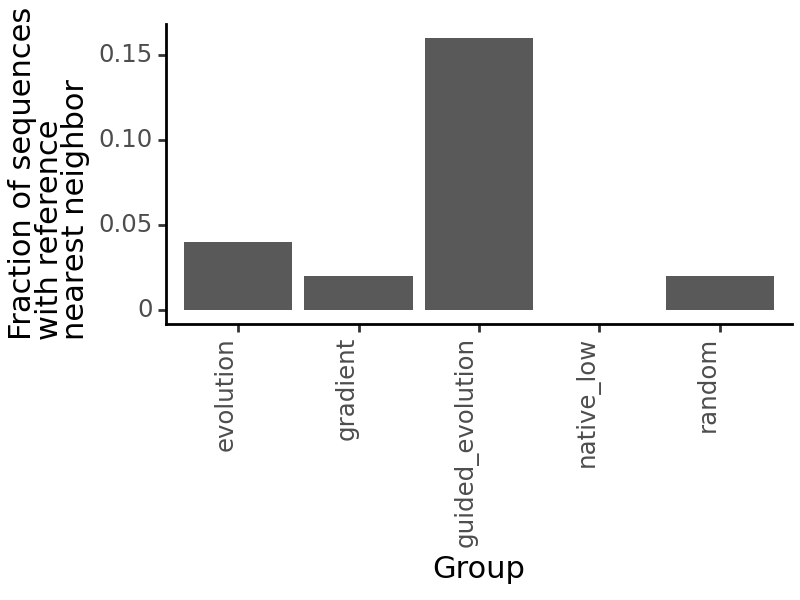

<Figure Size: (400 x 300)>

In [41]:
# 1-NN statistics
print(emb.uns["1NN_ref_prop_test"])
polygraph.visualize.one_nn_frac_plot(emb, reference_group="native_high") + p9.theme(figure_size=(4,3))

{'Kruskal': 1.8801825377028785e-36, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  6.13e-05          7.64e-01     3.47e-06   
gradient           6.13e-05  1.00e+00          1.94e-04     4.34e-18   
guided_evolution   7.64e-01  1.94e-04          1.00e+00     8.58e-07   
native_high        3.47e-06  4.34e-18          8.58e-07     1.00e+00   
native_low         5.91e-14  4.49e-04          4.45e-13     1.32e-34   
random             6.22e-02  3.48e-02          1.11e-01     6.40e-11   

                  native_low    random  
evolution           5.91e-14  6.22e-02  
gradient            4.49e-04  3.48e-02  
guided_evolution    4.45e-13  1.11e-01  
native_high         1.32e-34  6.40e-11  
native_low          1.00e+00  1.76e-08  
random              1.76e-08  1.00e+00  }


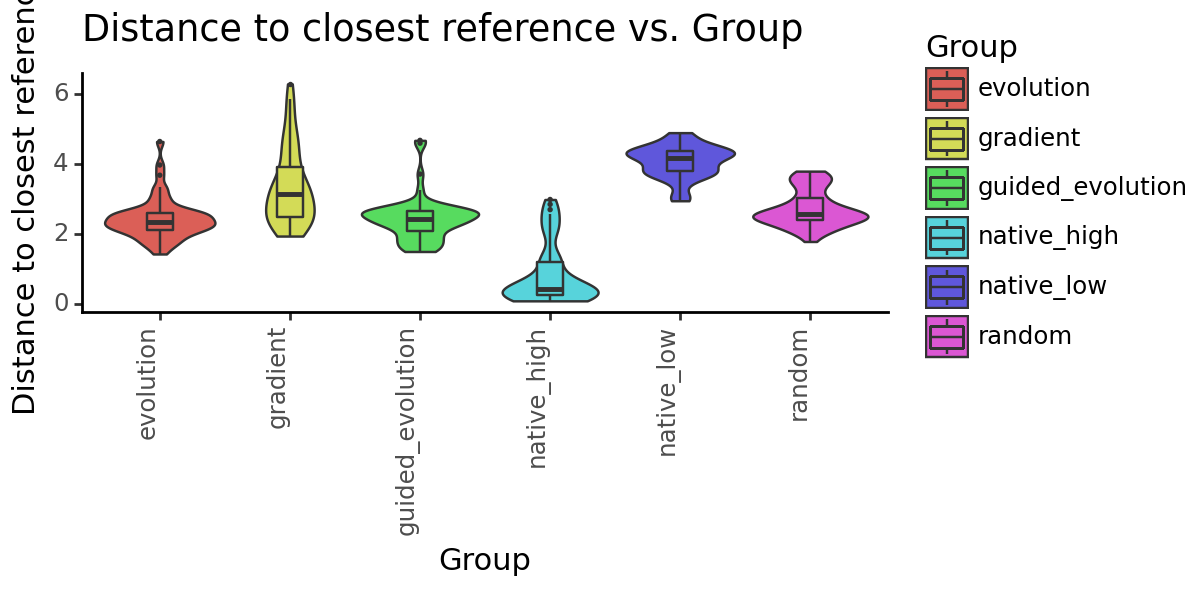

<Figure Size: (600 x 300)>

In [42]:
# Distance to the closest reference sequence
print(emb.uns['ref_dist_test'])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6, 3))

{'Kruskal': 6.69107587927871e-28, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  1.03e-01          2.63e-02     1.85e-04   
gradient           1.03e-01  1.00e+00          8.50e-05     6.30e-08   
guided_evolution   2.63e-02  8.50e-05          1.00e+00     1.47e-01   
native_high        1.85e-04  6.30e-08          1.47e-01     1.00e+00   
native_low         5.06e-11  1.01e-06          4.47e-19     2.11e-25   
random             6.58e-01  2.09e-01          8.08e-03     3.53e-05   

                  native_low    random  
evolution           5.06e-11  6.58e-01  
gradient            1.01e-06  2.09e-01  
guided_evolution    4.47e-19  8.08e-03  
native_high         2.11e-25  3.53e-05  
native_low          1.00e+00  7.46e-10  
random              7.46e-10  1.00e+00  }


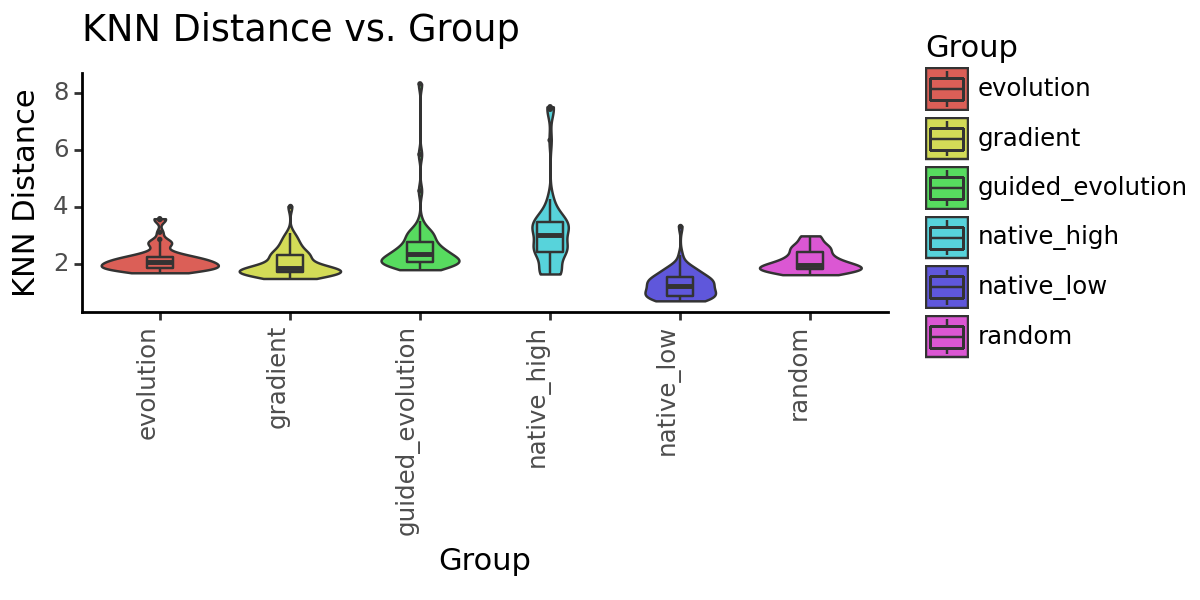

<Figure Size: (600 x 300)>

In [43]:
# KNN distance (diversity metric)
print(emb.uns['knn_dist_test'])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6,3))

In [44]:
# Performance of a classifier trained to separate each group from the reference
emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
native_low,1.0,1.0
random,1.0,1.0
evolution,1.0,1.0
gradient,1.0,1.0
guided_evolution,1.0,1.0


# 3. Evaluate motif content

In [100]:
importlib.reload(polygraph.motifs)

<module 'polygraph.motifs' from '/opt/conda/lib/python3.8/site-packages/polygraph/motifs.py'>

In [101]:
# Download JASPAR motifs
meme_file = polygraph.input.download_jaspar("fungi")

--2024-02-29 23:44:45--  https://jaspar.elixir.no/download/data/2024/CORE/JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt
Resolving jaspar.elixir.no (jaspar.elixir.no)... 158.39.201.109
Connecting to jaspar.elixir.no (jaspar.elixir.no)|158.39.201.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79182 (77K) [text/plain]
Saving to: ‘/opt/conda/lib/python3.8/site-packages/polygraph/resources/jaspar/JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt.3’

     0K .......... .......... .......... .......... .......... 64%  150K 0s
    50K .......... .......... .......                         100%  134M=0.3s

2024-02-29 23:44:46 (231 KB/s) - ‘/opt/conda/lib/python3.8/site-packages/polygraph/resources/jaspar/JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt.3’ saved [79182/79182]



In [102]:
%%time
# Scan all sequences with JASPAR motifs
sites = polygraph.motifs.scan(seqs, '/opt/conda/lib/python3.8/site-packages/polygraph/resources/jaspar/JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt')
sites.head()

Read 178 motifs from file.
CPU times: user 2.54 s, sys: 0 ns, total: 2.54 s
Wall time: 2.54 s


,MotifID,SeqID,start,end,strand,Group
0,ARG80,seq_242,6,11,+,gradient
93,ARR1,seq_242,61,68,+,gradient
199,ASH1,seq_242,13,4,-,gradient
571,DAL81,seq_242,12,30,+,gradient
628,DAL82,seq_242,31,23,-,gradient


## 3.1 Motif count embedding

In [103]:
# Calculate sequence x motif count matrix
counts = polygraph.motifs.motif_frequencies(sites, seqs=seqs, normalize=True)
counts.iloc[:5, :5]

,ABF1,ABF2,ACE2,ADR1,AFT1
SeqID,,,,,
seq_0,0.03,0.0,0.0,0.00,0.0
seq_1,0.00,0.0,0.0,0.00,0.0
seq_2,0.00,0.0,0.0,0.01,0.0
seq_3,0.03,0.0,0.0,0.00,0.0
seq_4,0.00,0.0,0.0,0.00,0.0


In [104]:
%%time
emb = polygraph.embedding.embedding_analysis(
    counts, seqs, reference_group='native_high')

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.8876453606343615
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers
CPU times: user 44.9 s, sys: 2.17 s, total: 47.1 s
Wall time: 1.35 s


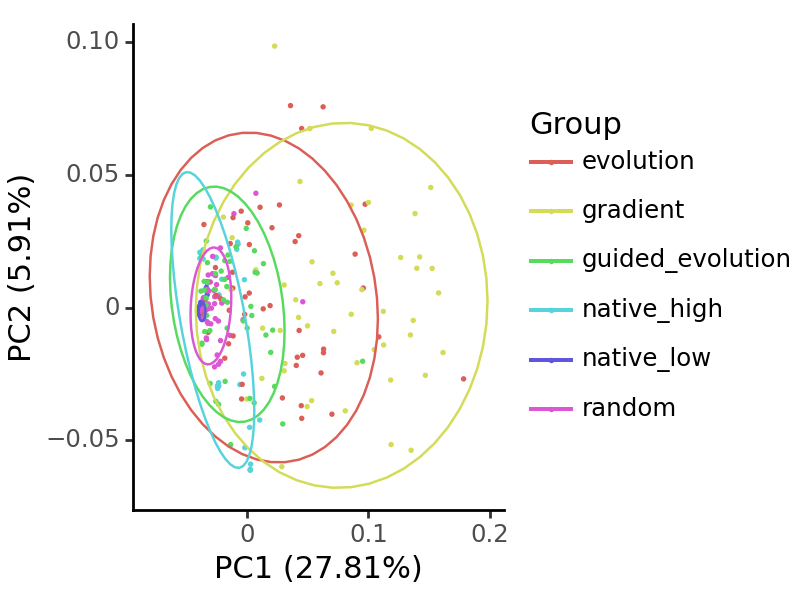

<Figure Size: (400 x 300)>

In [105]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(4,3))

In [106]:
# Differential motif abundance

print("Number of differential motifs compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential motifs")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head())

Number of differential motifs compared to reference
Group
gradient      31
evolution     13
native_low    13
random         3
Name: count, dtype: int64

Top Differential motifs
        Group  value  score      padj  log2FC
175  gradient  RSC30   7.65  3.46e-12    4.57
176  gradient   RSC3   6.94  3.55e-10    3.18
177  gradient   MBP1   6.55  3.38e-09    3.82
178  gradient   SUT1   6.24  1.89e-08    3.63
179  gradient  DAL81   5.93  1.05e-07    6.06


Fraction of sequences by 1-NN group
                  group_prop  ref_prop
Group                                 
native_low              0.00      0.94
random                  0.04      0.92
evolution               0.32      0.96
gradient                0.20      0.98
guided_evolution        0.58      0.94

p-values for proportion of sequences with native nearest neighbor
                  group_prop  ref_prop      pval      padj
Group                                                     
native_low              0.00      0.94  4.64e-25  2.32e-24
random                  0.04      0.92  6.07e-21  1.52e-20
evolution               0.32      0.96  6.22e-12  7.77e-12
gradient                0.20      0.98  5.13e-17  8.55e-17
guided_evolution        0.58      0.94  3.59e-05  3.59e-05


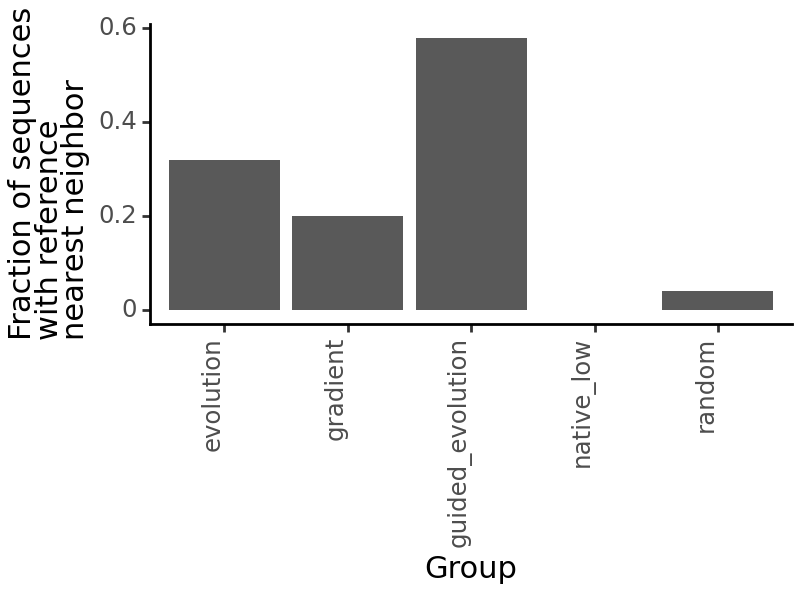

<Figure Size: (400 x 300)>

In [107]:
# 1-NN statistics
print("Fraction of sequences by 1-NN group")
print(emb.uns["1NN_group_probs"])

print("")

print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

# Plot
polygraph.visualize.one_nn_frac_plot(emb, reference_group="native_high") + p9.theme(figure_size=(4,3))

p-values for distance to closest reference
{'Kruskal': 1.1492403861288297e-43, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  3.88e-03          8.24e-04     1.64e-22   
gradient           3.88e-03  1.00e+00          3.61e-10     7.05e-37   
guided_evolution   8.24e-04  3.61e-10          1.00e+00     1.89e-10   
native_high        1.64e-22  7.05e-37          1.89e-10     1.00e+00   
native_low         8.09e-11  4.22e-21          1.68e-03     1.31e-03   
random             1.46e-04  2.68e-11          6.41e-01     2.86e-09   

                  native_low    random  
evolution           8.09e-11  1.46e-04  
gradient            4.22e-21  2.68e-11  
guided_evolution    1.68e-03  6.41e-01  
native_high         1.31e-03  2.86e-09  
native_low          1.00e+00  6.59e-03  
random              6.59e-03  1.00e+00  }


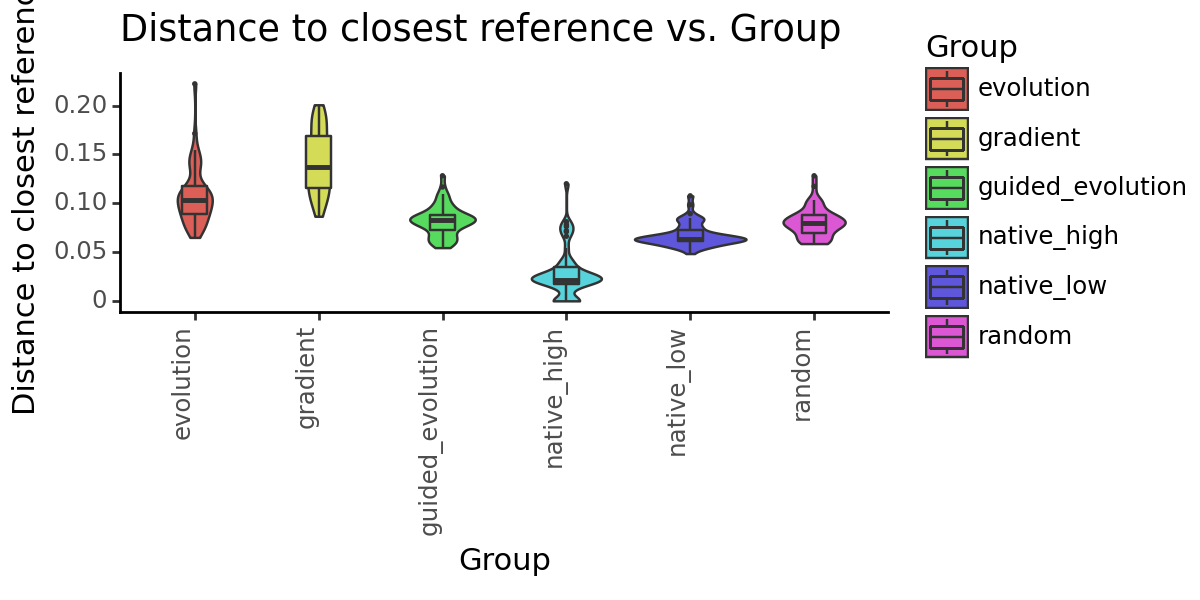

<Figure Size: (600 x 300)>

In [108]:
# Distance to closest reference sequence
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6,3))

p-values for KNN diversity
{'Kruskal': 9.231002304295897e-49, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  1.55e-02          6.96e-03     1.16e-12   
gradient           1.55e-02  1.00e+00          3.92e-07     1.81e-21   
guided_evolution   6.96e-03  3.92e-07          1.00e+00     1.19e-05   
native_high        1.16e-12  1.81e-21          1.19e-05     1.00e+00   
native_low         7.18e-25  4.26e-37          2.88e-14     1.42e-03   
random             3.13e-10  3.15e-18          3.39e-04     4.08e-01   

                  native_low    random  
evolution           7.18e-25  3.13e-10  
gradient            4.26e-37  3.15e-18  
guided_evolution    2.88e-14  3.39e-04  
native_high         1.42e-03  4.08e-01  
native_low          1.00e+00  6.73e-05  
random              6.73e-05  1.00e+00  }


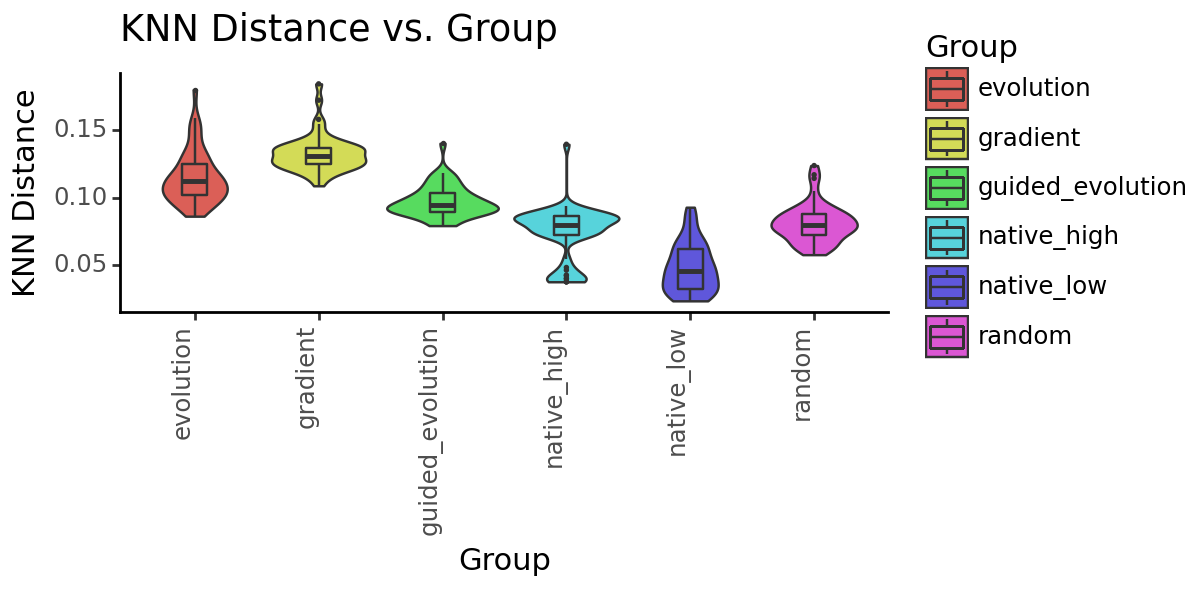

<Figure Size: (600 x 300)>

In [109]:
# KNN distance (diversity metric)
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6,3))

In [110]:
# Performance of a classifier trained to separate each group from the reference
emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
native_low,0.99,0.99
random,0.93,0.93
evolution,0.85,0.85
gradient,0.97,0.97
guided_evolution,0.83,0.83


## 3.2 motif positions

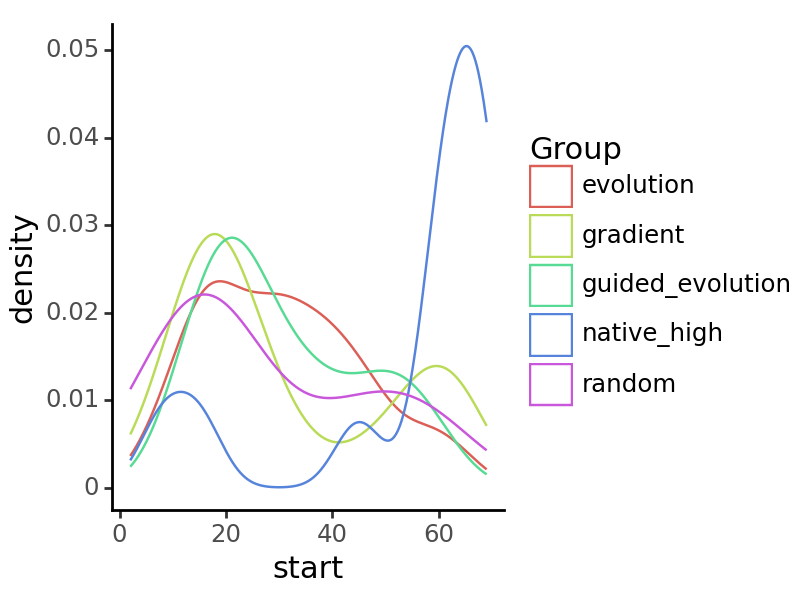

<Figure Size: (400 x 300)>

In [111]:
# Select the TF motif most enriched in synthetic sequences
polygraph.visualize.densityplot(sites[sites.MotifID=='RSC30'], value_col='start') + p9.theme(figure_size=(4,3))

## 3.3 Abundance of motif pairs

In [127]:
pairs = polygraph.motifs.get_motif_pairs(counts)

In [153]:
%%time
importlib.reload(polygraph.motifs)
pair_diff_abundance = polygraph.motifs.motif_pair_differential_abundance(counts, seqs, reference_group="native_high", min_group_prop=0.5)

Selected 57 pairs based on maximum in-group proportion
CPU times: user 1.11 s, sys: 3.86 ms, total: 1.11 s
Wall time: 1.11 s


In [113]:
print("Number of differential motif pairs compared to reference")
print(pair_diff_abundance[pair_diff_abundance.padj < .01].Group.value_counts())

print("")

print("Top Differential motif pairs")
print(pair_diff_abundance[pair_diff_abundance.padj < .01].sort_values('padj').head())

Number of differential motif pairs compared to reference
Group
gradient            444
evolution           141
native_low           73
random               39
guided_evolution     11
Name: count, dtype: int64

Top Differential motif pairs
         Group  group_prop  ref_prop      pval      padj      Matrix_id
478   gradient        0.86      0.02  2.03e-19  6.18e-16  (RSC3, RSC30)
848   gradient        0.78      0.00  8.29e-18  1.26e-14   (MBP1, RSC3)
503   gradient        0.80      0.02  5.13e-17  5.21e-14  (RSC30, TEA1)
648   gradient        0.78      0.02  2.73e-16  2.08e-13  (RSC30, SUT1)
1013  gradient        0.70      0.00  4.11e-15  1.56e-12   (MBP1, TEA1)


In [114]:
# Are there any significant motif combinations where neither individual motif is significant?
sig_motifs = emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].value.tolist()
sig_pairs = pair_diff_abundance[pair_diff_abundance.padj < .01]
sig_pairs_only = sig_pairs[sig_pairs.Matrix_id.apply(lambda c: (c[0] not in sig_motifs) and (c[1] not in sig_motifs))]

print("Number of differential motif pairs whose component motifs are not differentially abundant between groups")
print(sig_pairs_only.Group.value_counts())
print("\n")
print(sig_pairs_only.head())

Number of differential motif pairs whose component motifs are not differentially abundant between groups
Group
native_low    16
random         7
gradient       5
evolution      4
Name: count, dtype: int64


        Group  group_prop  ref_prop      pval      padj     Matrix_id
0  native_low        0.02      0.30  1.75e-04  9.81e-04  (ABF1, EDS1)
1      random        0.02      0.30  1.75e-04  9.81e-04  (ABF1, EDS1)
5  native_low        0.00      0.26  9.98e-05  5.90e-04  (ABF1, GCN4)
6      random        0.00      0.26  9.98e-05  5.90e-04  (ABF1, GCN4)
7   evolution        0.00      0.26  9.98e-05  5.90e-04  (ABF1, GCN4)


In [208]:
subset_seqs = seqs[seqs.Group.isin(["gradient", "native_high"])].index.tolist()

In [210]:
ab = polygraph.motifs.get_motif_pairs(counts[counts.index.isin(subset_seqs)])
ori = polygraph.motifs.motif_pair_orientation(sites[sites.SeqID.isin(subset_seqs)])
ab = ab.merge(
        seqs[["Group"]], left_index=True, right_index=True
    )
ori = ori.merge(
        seqs[["Group"]], left_index=True, right_index=True
    )

In [219]:
ab_cts = ab[["MotifID", "Group"]].reset_index().drop_duplicates()
ab_cts = ab_cts[["MotifID", "Group"]].value_counts()

In [220]:
ori_cts = ori[["MotifID", "Group"]].reset_index().drop_duplicates()
ori_cts = ori_cts[["MotifID", "Group"]].value_counts()

In [221]:
ab_cts

MotifID        Group      
(RSC3, RSC30)  gradient       43
(RSC3, TEA1)   gradient       40
(RSC30, TEA1)  gradient       40
(RSC30, SUT1)  gradient       39
(MBP1, RSC3)   gradient       39
                              ..
(MSN4, RPN4)   gradient        1
(MSN4, RPH1)   native_high     1
(MSN4, ROX1)   native_high     1
(MSN4, RLM1)   native_high     1
(OPI1, SRD1)   gradient        1
Name: count, Length: 12825, dtype: int64

In [222]:
ori_cts

MotifID            Group      
(RSC30, RSC30)     gradient       45
(RSC3, RSC30)      gradient       43
(TEA1, RSC30)      gradient       40
(TEA1, RSC3)       gradient       40
(MBP1, RSC30)      gradient       39
                                  ..
(MET31, NCU00019)  native_high     1
(SPT23, PHD1)      gradient        1
(SPT23, PDR1)      gradient        1
(MET31, NDT80)     native_high     1
(wc-1, wc-1)       native_high     1
Name: count, Length: 12974, dtype: int64

In [213]:
ab_filtered = polygraph.motifs._filter_motif_pairs(ab, seqs, min_group_freq=25)

Selected 57 pairs based on maximum in-group frequency


In [214]:
ori_filtered = polygraph.motifs._filter_motif_pairs(ori, seqs, min_group_freq=25)

Selected 62 pairs based on maximum in-group frequency


In [205]:
ab

,MotifID
SeqID,
seq_200,"(ADR1, ARO80)"
seq_200,"(ADR1, CHA4)"
seq_200,"(ADR1, DAL82)"
seq_200,"(ADR1, DOT6)"
seq_200,"(ADR1, GCR1)"
...,...
seq_249,"(ZMS1, nit-4)"
seq_249,"(ZMS1, rst2)"
seq_249,"(cre-1, nit-4)"


## 3.4 Orientation of motif pairs

In [154]:
importlib.reload(polygraph.motifs)
ori = polygraph.motifs.motif_pair_orientation(sites)

In [155]:
ori = ori.merge(seqs[['Group']], left_index=True, right_index=True)
ori

,MotifID,orientation,Group
SeqID,,,
seq_0,"(ARG80, INO4)",same,native_high
seq_0,"(ARG80, MAC1)",same,native_high
seq_0,"(ARG80, MOT3)",same,native_high
seq_0,"(ARG80, YAP5)",same,native_high
seq_0,"(ARG80, YAP7)",opposite,native_high
...,...,...,...
seq_99,"(THI2, DOT6)",same,native_low
seq_99,"(THI2, GCN4)",same,native_low
seq_99,"(TOD6, DOT6)",same,native_low


In [159]:
pairs = pairs.merge(seqs[['Group']], left_index=True, right_index=True)
pairs

,MotifID,Group
SeqID,,
seq_0,"(ABF1, ARG80)",native_high
seq_0,"(ABF1, ARG81)",native_high
seq_0,"(ABF1, CAD1)",native_high
seq_0,"(ABF1, EDS1)",native_high
seq_0,"(ABF1, GCN4)",native_high
...,...,...
seq_99,"(GCN4, THI2)",native_low
seq_99,"(GCN4, TOD6)",native_low
seq_99,"(STE12, THI2)",native_low


In [156]:
cts = ori[["MotifID", "Group"]].reset_index().drop_duplicates()
cts = cts[["MotifID", "Group"]].value_counts().reset_index(name="count")
cts

,MotifID,Group,count
0,"(RSC30, RSC30)",gradient,45
1,"(RSC3, RSC30)",gradient,43
2,"(TEA1, RSC3)",gradient,40
3,"(TEA1, RSC30)",gradient,40
4,"(MBP1, RSC30)",gradient,39
...,...,...,...
43089,"(RSC3, YAP6)",random,1
43090,"(IXR1, OAF1)",evolution,1
43091,"(RSC3, YAP6)",evolution,1
43092,"(IXR1, OPI1)",gradient,1


In [162]:
len(set(cts.MotifID[cts['count'] > 25]))

62

In [163]:
cts2 = pairs[["MotifID", "Group"]].reset_index().drop_duplicates()
cts2 = cts2[["MotifID", "Group"]].value_counts().reset_index(name="count")
cts2

,MotifID,Group,count
0,"(RSC3, RSC30)",gradient,43
1,"(RSC3, TEA1)",gradient,40
2,"(RSC30, TEA1)",gradient,40
3,"(MBP1, RSC3)",gradient,39
4,"(RSC30, SUT1)",gradient,39
...,...,...,...
42629,"(HAP2, RFX1)",random,1
42630,"(HAP2, RFX1)",native_low,1
42631,"(HAP2, RFX1)",guided_evolution,1
42632,"(HAP2, RFX1)",evolution,1


In [166]:
counts_sub = counts.loc[:, ["RSC3", "RSC30"]].copy()
sites_sub = sites[sites.MotifID.isin(["RSC3", "RSC30"])].copy()

In [170]:
len(counts_sub[(counts_sub.min(1) > 0) & (counts_sub.index.isin(seqs[seqs.Group=="gradient"].index))])

43

In [177]:
sum(sites_sub[sites_sub.Group=="gradient"].groupby('SeqID').MotifID.apply(lambda x: np.sort(np.unique(x.tolist()))).apply(len)==2)

43

In [182]:
%%time
importlib.reload(polygraph.motifs)
pair_diff_orientation = polygraph.motifs.motif_pair_differential_orientation(sites, seqs, reference_group="native_high", min_group_prop=0.5)

Selected 62 pairs based on maximum in-group proportion
CPU times: user 3.35 s, sys: 15.9 ms, total: 3.37 s
Wall time: 3.37 s


In [ ]:
print("Number of differentially oriented motif pairs compared to reference")
print(pair_diff_orientation[pair_diff_orientation.padj < .01].Group.value_counts())

print("")

print("Top Differentially oriented motif pairs")
print(pair_diff_orientation[pair_diff_orientation.padj < .01].sort_values('padj').head())

gradient      31
evolution     13
native_low    13
random         3
Name: Group, dtype: int64

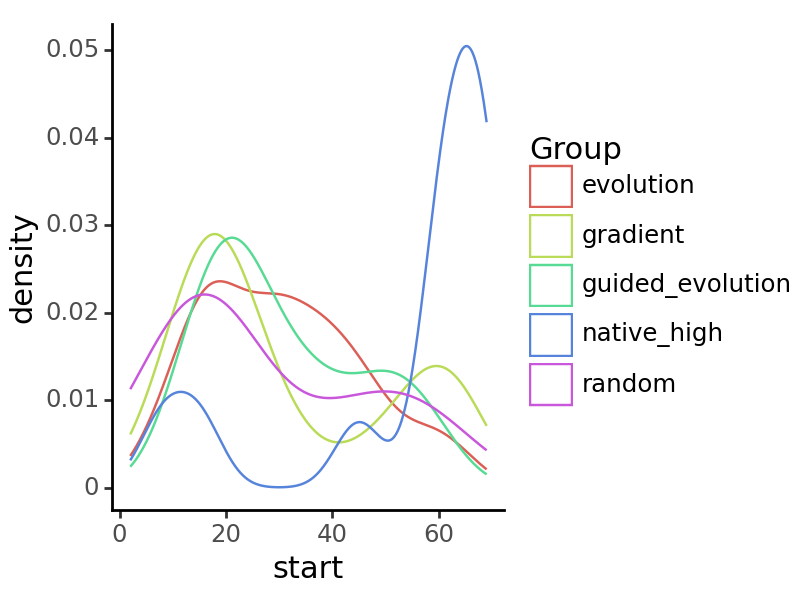

<Figure Size: (400 x 300)>

In [51]:
polygraph.stats.kruskal_dunn(sites[sites.MotifID=='RSC30'], val_col='start')

{'Kruskal': 0.00642637465639194,
 'Dunn':                   evolution  gradient  guided_evolution  native_high    random
 evolution          1.00e+00  5.79e-01          8.88e-01     5.41e-03  5.79e-01
 gradient           5.79e-01  1.00e+00          5.79e-01     2.66e-03  5.79e-01
 guided_evolution   8.88e-01  5.79e-01          1.00e+00     8.42e-03  5.79e-01
 native_high        5.41e-03  2.66e-03          8.42e-03     1.00e+00  7.68e-03
 random             5.79e-01  5.79e-01          5.79e-01     7.68e-03  1.00e+00}

## 3.4 NMF

In [53]:
%%time
# NMF to identify co-occurring groups of motifs ('factors')
# And their contribution to each sequence
W, H, p = polygraph.motifs.nmf(counts, seqs, reference_group='native_high', n_components=10)

CPU times: user 1.78 s, sys: 5.13 s, total: 6.91 s
Wall time: 110 ms


In [54]:
p[p.padj < .05].Group.value_counts()

evolution           8
gradient            8
random              7
native_low          5
guided_evolution    4
Name: Group, dtype: int64

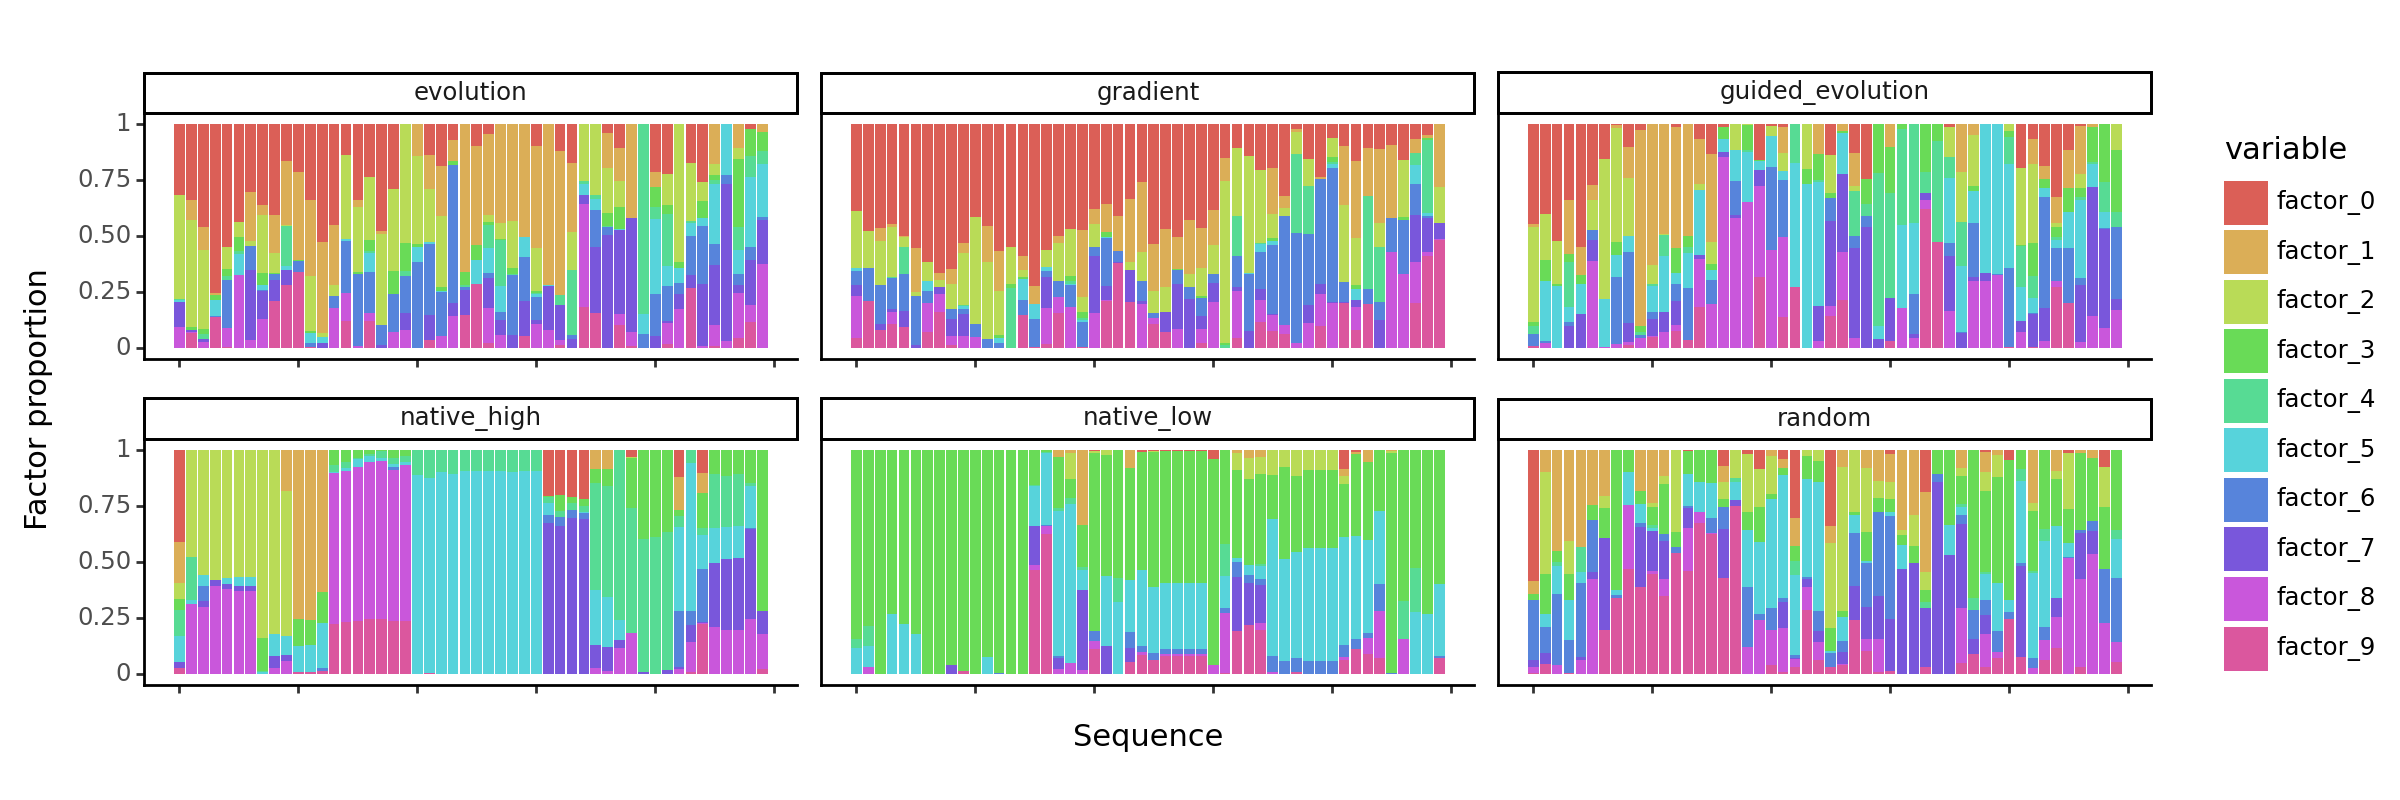

<Figure Size: (1200 x 400)>

In [55]:
polygraph.visualize.plot_seqs_nmf(W) + p9.theme(figure_size=(12, 4))

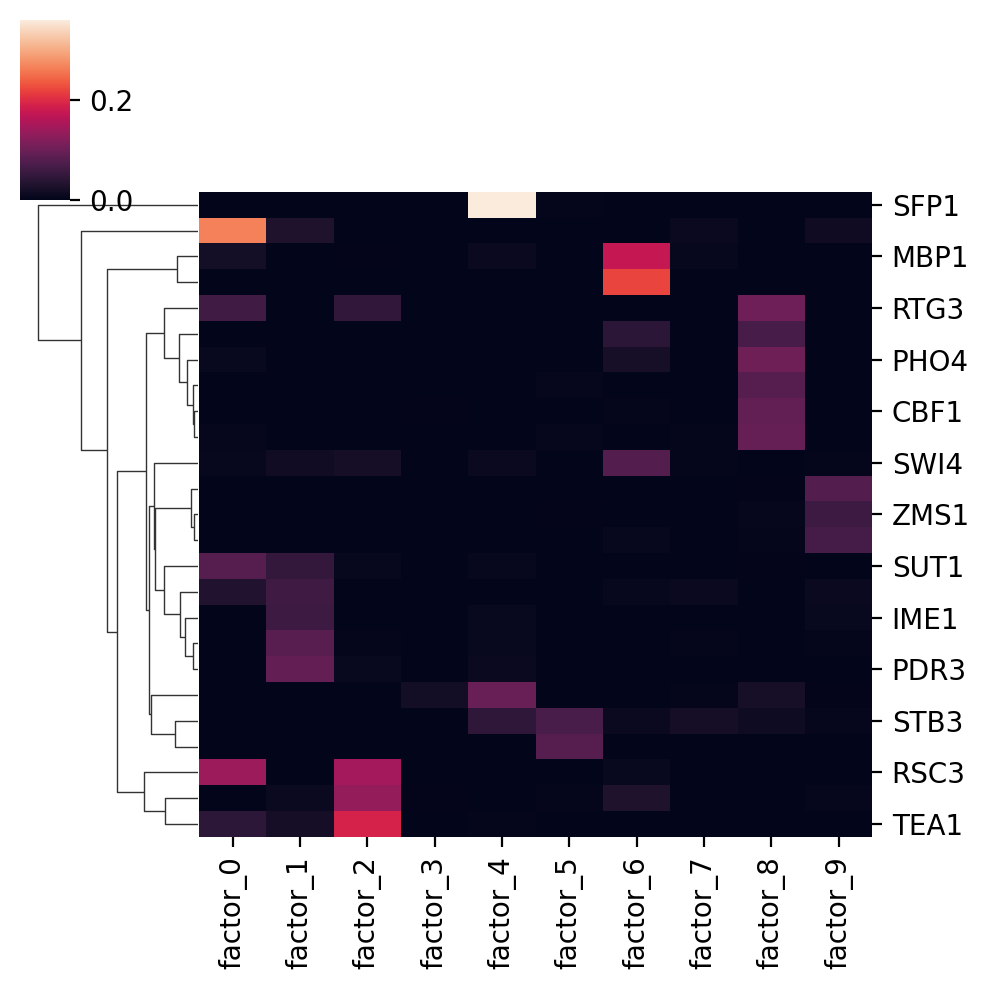

In [56]:
# Motifs that contribute to each factor
polygraph.visualize.plot_factors_nmf(H, n_features=25, figsize=(5,5))

## 3.5 Filter important motifs by ISM

In [57]:
# Calculate an importance score for each base in each sequence using In Silico Mutagenesis
ism = polygraph.models.ism_score(model, seqs, batch_size=512, device=0)
ism.shape

(300, 80)

In [58]:
# Score each motif site by its average ISM score
sites = polygraph.motifs.score_sites(sites, seqs, ism)
sites.head()

,MotifID,SeqID,start,end,strand,Group,score
0,ARG80,seq_242,6,11,+,gradient,9.36e-03
93,ARR1,seq_242,61,68,+,gradient,3.89e-03
199,ASH1,seq_242,13,4,-,gradient,8.03e-03
571,DAL81,seq_242,12,30,+,gradient,6.68e-03
628,DAL82,seq_242,31,23,-,gradient,7.50e-03


In [59]:
# Select the top 50 motifs by max importance across the dataset
top_motifs = sites.groupby('MotifID').score.max().sort_values(ascending=False).head(50).index.tolist()
top_motifs[:5]

['ASG1', 'ECM22', 'YER184C', 'SIP4', 'PUT3']

In [60]:
# Count sites only of these motifs
top_motif_sites = sites[sites.MotifID.isin(top_motifs)]

In [61]:
counts = polygraph.motifs.motif_frequencies(top_motif_sites, seqs=seqs, normalize=True)
counts.iloc[:5, :5]

,ABF1,ACE2,ADR1,ASG1,CAT8
SeqID,,,,,
seq_0,0.03,0.0,0.00,0.0,0.0
seq_1,0.00,0.0,0.00,0.0,0.0
seq_2,0.00,0.0,0.01,0.0,0.0
seq_3,0.03,0.0,0.00,0.0,0.0
seq_4,0.00,0.0,0.00,0.0,0.0


In [62]:
emb = polygraph.embedding.embedding_analysis(
    counts, seqs, reference_group='native_high')

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  1.0
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers


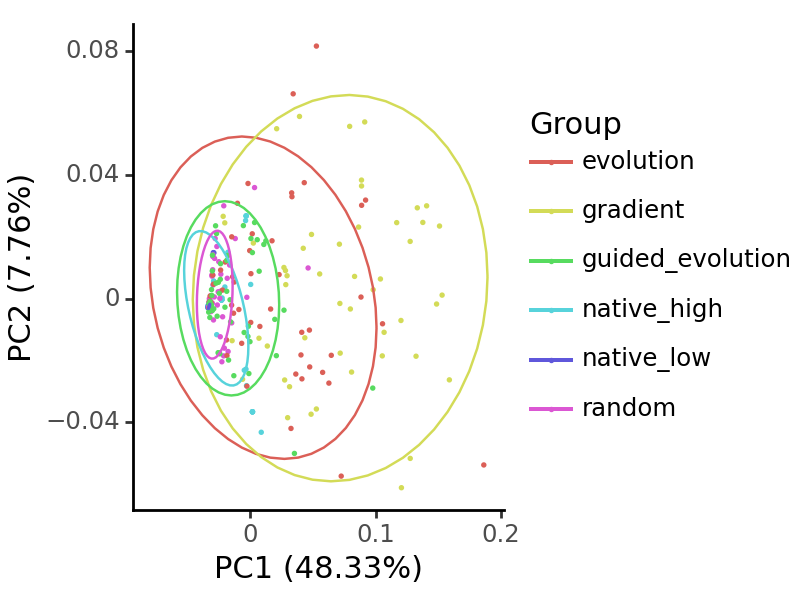

<Figure Size: (400 x 300)>

In [63]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(4,3))

p-values for distance to closest reference
{'Kruskal': 8.222975311037462e-47, 'Dunn':                   evolution  gradient  guided_evolution  native_high  \
evolution          1.00e+00  2.71e-03          5.05e-03     3.26e-21   
gradient           2.71e-03  1.00e+00          7.09e-09     1.05e-35   
guided_evolution   5.05e-03  7.09e-09          1.00e+00     3.19e-11   
native_high        3.26e-21  1.05e-35          3.19e-11     1.00e+00   
native_low         8.98e-15  3.39e-27          6.65e-07     9.51e-02   
random             1.26e-04  9.19e-12          2.89e-01     2.10e-08   

                  native_low    random  
evolution           8.98e-15  1.26e-04  
gradient            3.39e-27  9.19e-12  
guided_evolution    6.65e-07  2.89e-01  
native_high         9.51e-02  2.10e-08  
native_low          1.00e+00  9.11e-05  
random              9.11e-05  1.00e+00  }


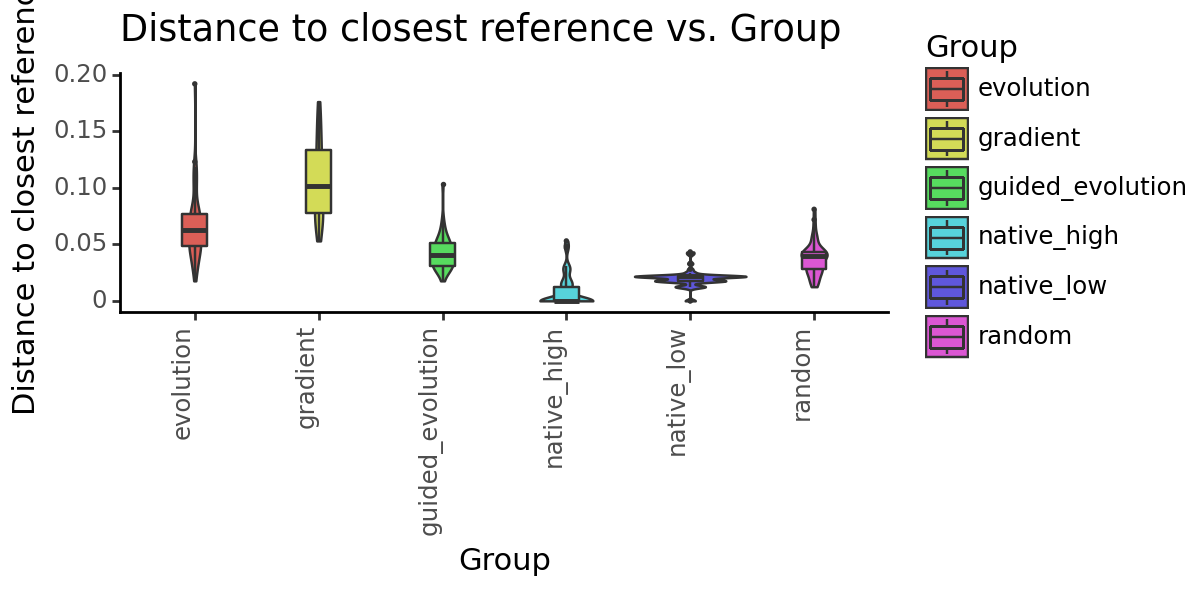

<Figure Size: (600 x 300)>

In [64]:
# Distance to reference
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6,3))